In [6]:
import main
import pandas as pd
from matplotlib import pyplot as plt

In [7]:
data = main.load_eurusd_data("histdata_free/", 2023)

In [8]:
features_df = {
        "mean_short": main.get_ewm_macd(data, 3, 15),
        "mean_medium": main.get_ewm_macd(data, 5, 25),
        # "mean_medium2": main.get_ewm_macd(data, 1440, 7200),
        # "mean_long": main.get_ewm_macd(data, 1440, 43200),
        "pinbar": main.get_pinbar(data),
        # "gk_vol": main.get_garman_klass(data),
        "fwd_rets": data["Close"].diff().shift(-1),
} | {
    f"previous_return_{i}": data["Close"].pct_change().shift(i) for i in range(1,10)
}
features_df = pd.DataFrame(features_df).dropna()

In [9]:
results_df = main.rolling_regression_forecast(features_df)

Out-of-sample MSE: 2.127232224278406e-08
Out-of-sample MAPE: 1528199607.722945
Correlation between y and y^: 0.0071389075408927576


In [11]:
data

,Open,High,Low,Close,Volume,Range,Body,UpperShadow,LowerShadow
DateTime,,,,,,,,,
2023-01-01 17:04:00,1.06970,1.06974,1.06970,1.06970,0,0.00004,0.00000,0.00004,0.00000
2023-01-01 17:05:00,1.06973,1.06978,1.06970,1.06971,0,0.00008,0.00002,0.00005,0.00001
2023-01-01 17:06:00,1.06966,1.06966,1.06966,1.06966,0,0.00000,0.00000,0.00000,0.00000
2023-01-01 17:08:00,1.06970,1.06974,1.06970,1.06974,0,0.00004,0.00004,0.00000,0.00000
2023-01-01 17:10:00,1.06975,1.06980,1.06972,1.06972,0,0.00008,0.00003,0.00005,0.00000
...,...,...,...,...,...,...,...,...,...
2023-12-29 16:54:00,1.10388,1.10390,1.10387,1.10388,0,0.00003,0.00000,0.00002,0.00001
2023-12-29 16:55:00,1.10389,1.10395,1.10387,1.10395,0,0.00008,0.00006,0.00000,0.00002
2023-12-29 16:56:00,1.10394,1.10394,1.10367,1.10370,0,0.00027,0.00024,0.00000,0.00003


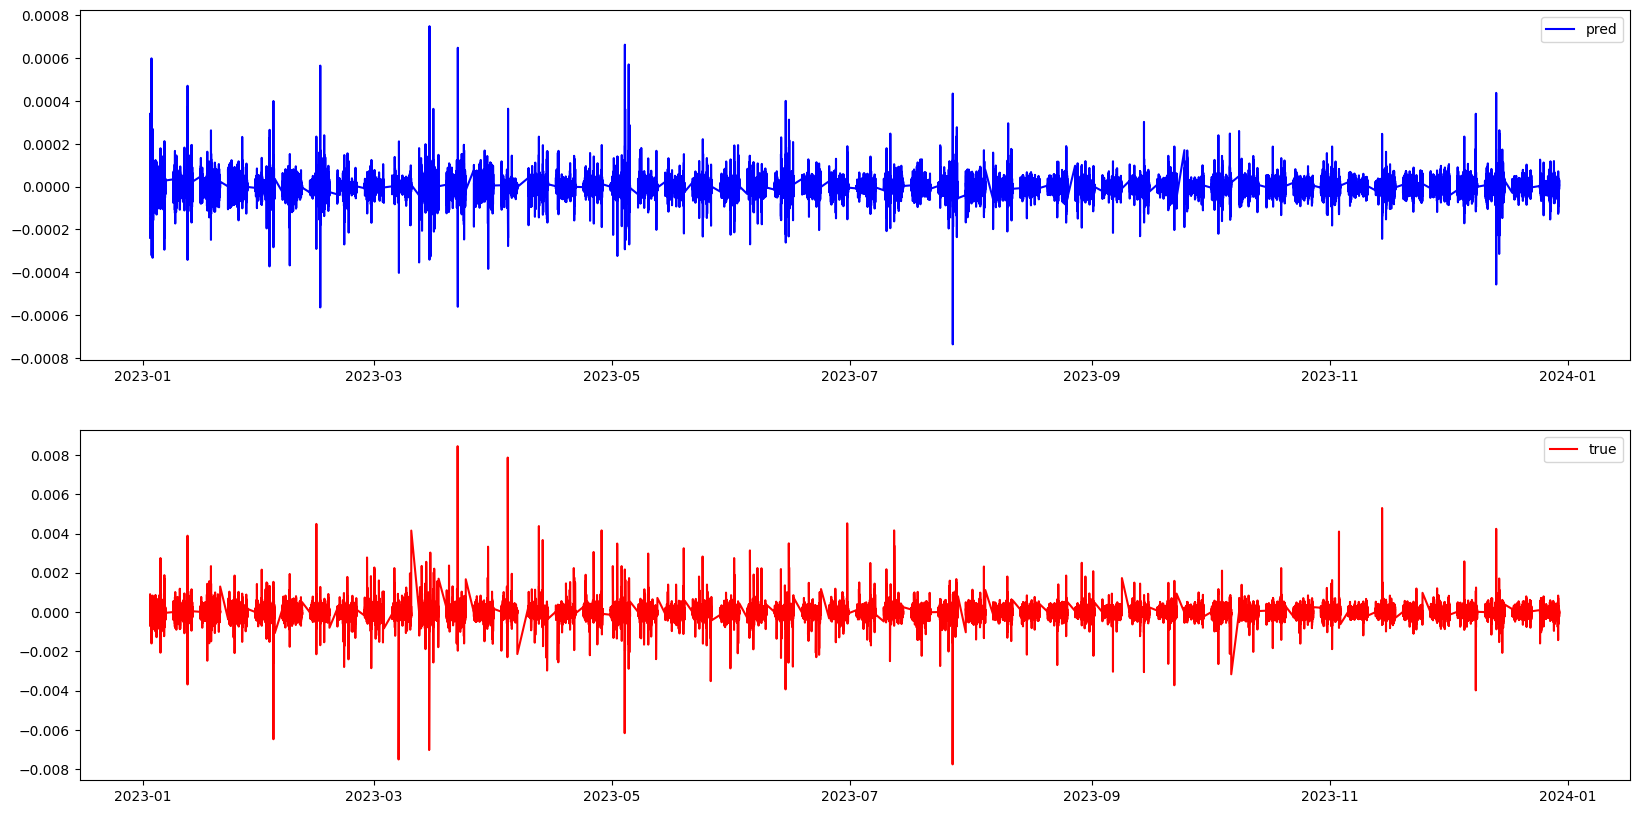

In [6]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(results_df.iloc[:,1], label = "pred", color = "blue")
ax[1].plot(results_df.iloc[:,0], label = "true", color = "red")
ax[0].legend()
ax[1].legend()
